In [1]:
import numpy
import mitsuba as mi 
mi.set_variant("cuda_ad_rgb")
import matplotlib.patches as patches
import drjit as dr
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from PDE2D.Coefficient import *
from PDE2D.utils import *
from PDE2D.BoundaryShape import *
from PDE2D.Solver import *
from PDE2D.Solver.constant.wos_constant import Particle
from PDE2D import GreenSampling

In [2]:
green = GreenSampling.Polynomial
conf_numbers = [UInt32(0), UInt32(1)]
conf_vis = 0


In [3]:
source_p = {}
source_p["radius"] = 0.5
source_p["val"] = 0



def source(points, params):
    return dr.select(dr.norm(points) <= params["radius"], params["val"], 0.0)

f = FunctionCoefficient("f", source_p, source)

In [4]:


def boundary(points, parameters):
    angle = dr.atan2(points[0], points[1])
    return parameters["scale"] * dr.sin(angle * parameters["freq"]) + parameters["bias"]
parameters1_d = {}
parameters1_d["freq"] = 2
parameters1_d["bias"] = 6
parameters1_d["scale"] = 12
parameters2_d = {}
parameters2_d["freq"] = 4
parameters2_d["bias"] = 4
parameters2_d["scale"] = 8

dirichlet1 = FunctionCoefficient("dirichlet", parameters1_d, boundary)
dirichlet2 = FunctionCoefficient("dirichlet", parameters2_d, boundary)

points = create_circle_points(radius = 1, resolution =3, spp = 1, discrete_points = True, centered = False)
normals = dr.normalize(points)
dirichlet_map = [True, False, False]
angle_partition = [np.pi/2, np.pi, 3 * np.pi/2]
shape = QuadraticBezierShape(points.numpy(), normals.numpy(), dirichlet = [dirichlet1, dirichlet2], neumann = [ConstantCoefficient("neumann", 5000)],
                             dirichlet_map = dirichlet_map, n_segment = 20, newton_steps = 5, epsilon = 1e-3)

In [5]:
bbox = [[-1.3, -1.3], [1.3, 1.3]]
resolution_image = [256, 256]
spp_image = 1024
epsilon = 1e-5

res = 128
spp_boundary = 2 ** 18

radius = 1
computation_radius = 0.7

σ = ConstantCoefficient("screening", 10)
#shape = CircleShape(radius = 1.2, dirichlet = [dirichlet], angle_partition=angle_partition, dirichlet_map = dirichlet_map)
data_holder = DataHolder(shape = shape, σ = σ, f=f)

computation_shape = CircleShape(radius = computation_radius)

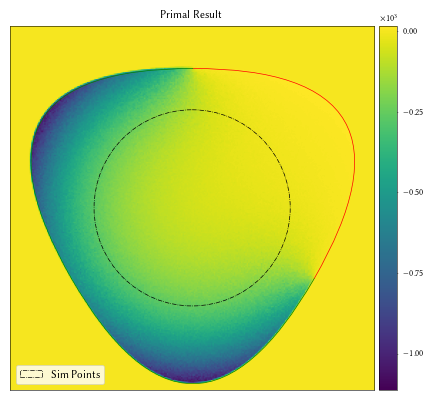

In [6]:
points = create_image_points(bbox, resolution_image, spp_image)
wos = WostConstant(data_holder, green_sampling=green)
L, p = wos.solve(points_in = points, conf_numbers = conf_numbers)
image_0, tensor = create_image_from_result(L, resolution_image)
fig, (ax1) = plt.subplots(1, 1, figsize=[5, 5])
plot_image(image_0[conf_vis], ax1)
ax1.set_title("Primal Result")
shape.sketch(ax1, bbox, resolution_image)
rplot =  computation_radius * resolution_image[0] / (bbox[1][1] - bbox[0][1])
sphere = patches.Ellipse([resolution_image[0]/2 - 0.5, resolution_image[0]/2 -0.5], 
                         rplot * 2, rplot * 2, 
                         fill = False, color = "black", label = "Sim Points", ls="-.")
ax1.add_patch(sphere)
ax1.legend(loc = "lower left", fontsize = 8)

In [7]:
points, _, normal_dir = computation_shape.create_boundary_points(distance=0, res = res, spp = spp_boundary)
L, p = wos.solve(points_in = points, conf_numbers = conf_numbers)
tensor, tensor_mi = computation_shape.create_boundary_result(L, resolution = res)
boundary_dirichlet = computation_shape.create_boundary_coefficient(tensor_mi)

In [8]:
L, p = wos.solve(points_in = points, derivative_dir = -dr.normalize(points),  conf_numbers=conf_numbers)
tensor, tensor_mi = computation_shape.create_boundary_result(L, resolution = res)
boundary_neumann= computation_shape.create_boundary_coefficient(tensor_mi)

/tmp/ipykernel_3050737/978539011.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="lower left", fontsize=8)


Text(0.5, 1.0, 'Dirichlet Cut')

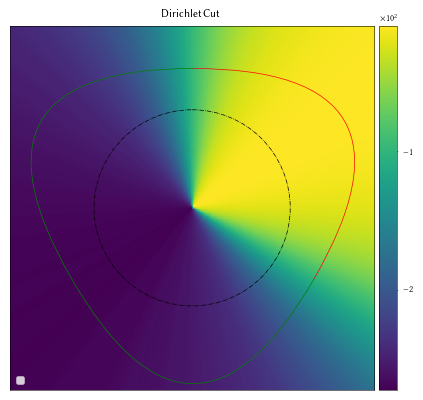

In [9]:
fig, (ax) = plt.subplots(1, 1, figsize=[5, 5])
boundary_dirichlet[conf_vis].visualize(ax, bbox, resolution= resolution_image)
shape.sketch(ax, bbox, resolution_image)
ax.legend(loc="lower left", fontsize=8)
rplot =  computation_radius * resolution_image[0] / (bbox[1][1] - bbox[0][1])
sphere = patches.Ellipse([resolution_image[0]/2 - 0.5, resolution_image[0]/2 -0.5], 
                         rplot * 2, rplot * 2, 
                         fill = False, color = "black", label = "Sim Points", ls="-.")
ax.add_patch(sphere)
ax.set_title("Dirichlet Cut")

Text(0.5, 1.0, 'Neumann Cut')

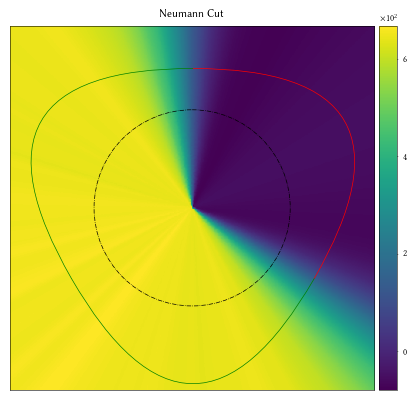

In [10]:
fig, (ax) = plt.subplots(1, 1, figsize=[5, 5])
boundary_neumann[0].visualize(ax, bbox, resolution= resolution_image)
shape.sketch(ax, bbox, resolution_image)

rplot =  computation_radius * resolution_image[0] / (bbox[1][1] - bbox[0][1])
sphere = patches.Ellipse([resolution_image[0]/2 - 0.5, resolution_image[0]/2 -0.5], 
                         rplot * 2, rplot * 2, 
                         fill = False, color = "black", label = "Sim Points", ls="-.")
ax.add_patch(sphere)
ax.set_title("Neumann Cut")

In [ ]:
angle_partition1 = np.array([0, 3 * np.pi/4, np.pi, 7 * np.pi / 4])
dirichlet_map1 = np.array([1, 0, 1, 0])

angle_partition2 = np.array([0, 3 * np.pi/4, np.pi, 7 * np.pi / 4])
dirichlet_map2 = np.array([0, 1, 0, 1])
shape1 = CircleShape(origin=Point2f(0., 0.), radius=computation_radius, epsilon= epsilon,dirichlet=boundary_dirichlet, neumann = boundary_neumann,
                     angle_partition=angle_partition1, dirichlet_map=dirichlet_map1)
data_holder1 = DataHolder(shape = shape1, σ=σ, f=f)

shape2 = CircleShape(origin=Point2f(0., 0.), radius=computation_radius, epsilon= epsilon,dirichlet=boundary_dirichlet, neumann = boundary_neumann,
                     angle_partition=angle_partition2, dirichlet_map=dirichlet_map2)
data_holder2 = DataHolder(shape = shape2, σ=σ, f=f)

In [12]:
bbox_ = [[-1.05 * computation_radius, -1.05 * computation_radius], [1.05 * computation_radius, 1.05 * computation_radius]]
points = create_image_points(bbox_, resolution_image, spp_image)
wos1 = WostConstant(data_holder1, green_sampling = green)
L1, _ = wos1.solve(points_in = points, conf_numbers = conf_numbers)
image1, tensor = create_image_from_result(L1, resolution_image)
wos2 = WostConstant(data_holder2, green_sampling = green)
L2, _ = wos2.solve(points_in = points, conf_numbers = conf_numbers)
image2, tensor = create_image_from_result(L2, resolution_image)

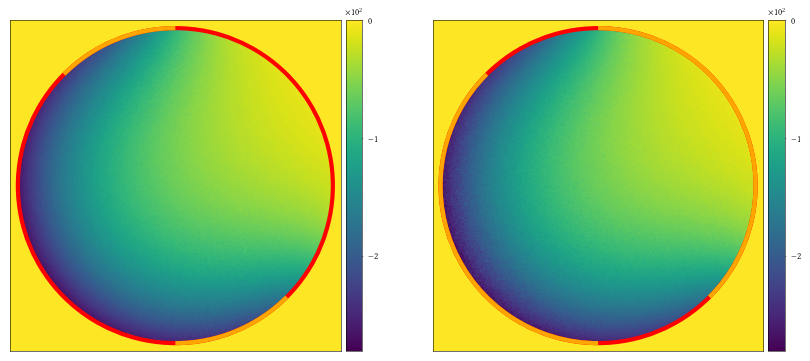

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10, 5])
max_val = max(image1.max(), image2.max())
min_val = min(image1.min(), image2.min())
range_ = [min_val, max_val]
plot_image(image1[conf_vis], ax1, input_range=range_)
shape1.sketch(ax1, bbox_, resolution_image)
plot_image(image2[conf_vis], ax2, input_range=range_)
shape2.sketch(ax2, bbox_, resolution_image)

Mean:
-0.010718013
Variance:
5.482639


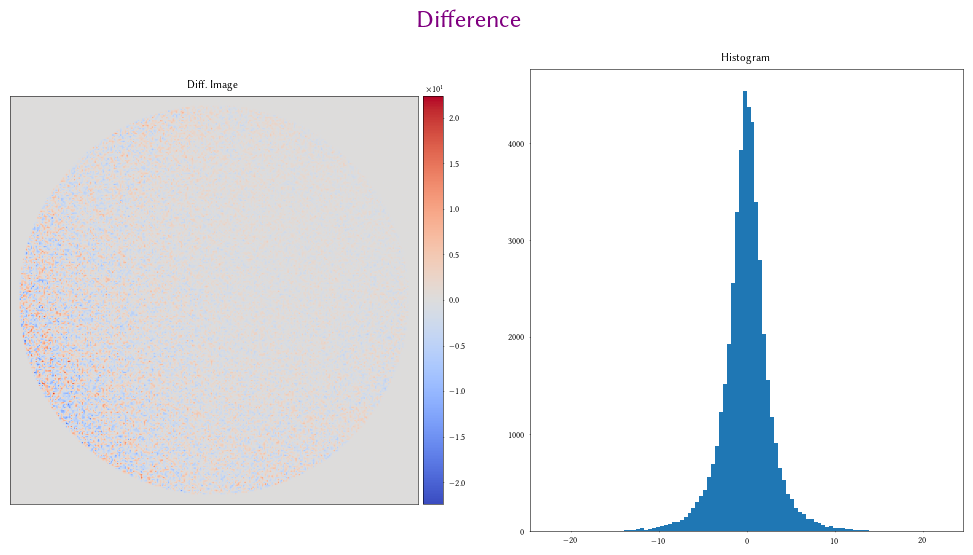

: 

In [14]:
sketch_diff(image1[conf_vis], image2[conf_vis], max_range = 1000)